#### 1. Import Libraries 

In [1]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib notebook

In [2]:
PATH = "/home/khan74/scratch/new_DL_DES/"
sz=224
batch_size=64

In [3]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50, Xception
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd 
import numpy as np

In [5]:
import os
from os import listdir, makedirs
from os.path import isfile, join, exists

#### 2. Load Data / Create data_generators

In [6]:
train_df = pd.read_csv(PATH + 'deeplearning/data/training_set.csv')
val_df = pd.read_csv(PATH + 'deeplearning/data/validation_set.csv')
HP_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/high_prob_crossmatch_test_set.csv')
FO_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/full_overlap_crossmatch_test_set.csv')

##### flow_from_dir

In [7]:
train_data_dir = f'{PATH}deeplearning/data/train/'
validation_data_dir = f'{PATH}deeplearning/data/valid/'

HP_SDSS_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/sdss/'
HP_DES_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/des/'

FO_SDSS_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/sdss/'
FO_DES_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/des/'

In [8]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)




train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (sz, sz),
batch_size = batch_size, 
class_mode = "categorical",
shuffle = True,
interpolation = 'nearest')

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = "categorical",
shuffle = False,
interpolation = 'nearest')




HP_SDSS_test_generator = test_datagen.flow_from_directory(
HP_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

HP_DES_test_generator = test_datagen.flow_from_directory(
HP_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)




FO_SDSS_test_generator = test_datagen.flow_from_directory(
FO_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

FO_DES_test_generator = test_datagen.flow_from_directory(
FO_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 36620 images belonging to 2 classes.
Found 963 images belonging to 2 classes.
Found 1066 images belonging to 1 classes.
Found 1066 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.


#### 3. Load Model 

In [9]:
model_final = load_model(PATH + 'deeplearning/weights/Xception_Final.h5')

#### 4. Load sklearn / Def metrics 

In [10]:
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure_size = (11, 6),
                          save=0,
                          save_path='/home/khan74'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=figure_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if save:
        plt.savefig(save_path)
        #plt.savefig('confusion_matrix.png')

In [12]:
# Define probability threshold mask

def threshold_mask(pred_array, prob_threshold = 0.9999):
    ''' 
    returns the positions in the array where the probability for each class is greater than prob_threshold
    
    pred_array: A one-hot encoded array of softmax probability outputs 
    prob_threshold: Float b/w 0 and 1 to use as a threshold mask
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.where( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] > prob_threshold )[0]
    return pos


In [13]:
# Define top n predictions mask

def top_pred_mask(pred_array, n_top_predictions = 5000 ):
    '''
    reversedurn the positions of top n most confident predictions
    
    pred_array: A one-reversedencoded array of softmax probability outputs
    n_top_predictions: Num of top predictions
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.argsort( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] ) 
    mask = np.flip( pos )
    return mask[: n_top_predictions]

# Tensorboard 

## 1. FO DES 

### Masking 

In [14]:
FO_DES_test_generator_NEW = valid_datagen.flow_from_directory(
FO_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 12596 images belonging to 1 classes.


In [15]:
FO_DES_predictions = model_final.predict_generator(FO_DES_test_generator_NEW, verbose=1)

12596/12596 [==============================] - 158s 13ms/step


In [16]:
mask = top_pred_mask(FO_DES_predictions, 5000)

In [17]:
FO_DES_predicted_class_indices=np.argmax(FO_DES_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_DES_predicted_class_indices] )

filenames= np.array( FO_DES_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred_Labels":predictions[mask],
                     "Predictions":FO_DES_predicted_class_indices[mask]})

In [18]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64')
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']
final['Actual_Labels'] = final.apply(lambda row: 's' \
                                        if row.P_CS_DEBIASED > row.P_EL_DEBIASED \
                                        else 'e', axis=1)
final.Filename = final['Filename'].apply(lambda x: x.split('/')[-1] )

In [19]:
final[['OBJID', 'Filename', 'Actuals', 'Predictions', 'Actual_Labels', 'Pred_Labels']].head()

,OBJID,Filename,Actuals,Predictions,Actual_Labels,Pred_Labels
0,100005001,100005001.png,True,1,s,spiral
1,138459097,138459097.png,True,1,s,spiral
2,260728929,260728929.png,True,1,s,spiral
3,260775373,260775373.png,True,1,s,spiral
4,260775390,260775390.png,False,0,e,elliptical


In [20]:
metrics.accuracy_score(np.array(final.Actuals), np.array(final.Predictions))

0.9754

### A.  Tensorboard Metadata  

In [21]:
tsne_generator = valid_datagen.flow_from_dataframe(
dataframe = final,
directory = FO_DES_test_data_dir+ 'test/',
x_col = 'Filename',
y_col = 'Actual_Labels',
has_ext = True,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 5000 images.


In [22]:
clustering_model = Model(input = model_final.input, output = model_final.get_layer('second_last_layer').output)

/home/khan74/.conda/envs/myanaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [23]:
FO_DES_out = clustering_model.predict_generator(tsne_generator, verbose=1)

5000/5000 [==============================] - 50s 10ms/step


In [24]:
x_test = tsne_generator[0]

for i in range(tsne_generator.n - 1):
    x_test = np.concatenate( (x_test, tsne_generator[i+1]), axis=0 )

In [25]:
x_test.shape

(5000, 224, 224, 3)

#### Create Labels

In [26]:
labels=[]

for file in tsne_generator.filenames:
    labels.append( list(final.Actual_Labels[ final.Filename == file]) )

In [27]:
labels = np.squeeze(labels)

In [28]:
log_dir = PATH + '/deeplearning/tensorboard/metadata/FO_DES/'

if not exists(log_dir):
    makedirs(log_dir)

In [29]:
labels = np.array(labels)

# save class labels to disk to color data points in TensorBoard accordingly
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, labels, fmt="%s")

#### Create Sprites 

In [30]:
from scipy.misc import imresize

In [31]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    #img_h = images.shape[1]
    #img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    img_h = int(8192 / n_plots)         # tensorboard supports sprite images up to 8192 x 8192
    img_w = int(8192 / n_plots)
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                this_img = imresize( this_img, (img_h, img_w))
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage, img_w, img_h

In [32]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [33]:
def invert_grayscale(gray):
    """ Makes black white, and white black """
    return 1-gray

In [34]:
test_image = rgb2gray(x_test)

In [35]:
test_image = invert_grayscale(test_image)

In [36]:
sprite_image, img_w, img_h = create_sprite_image(test_image)

/home/khan74/.conda/envs/myanaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


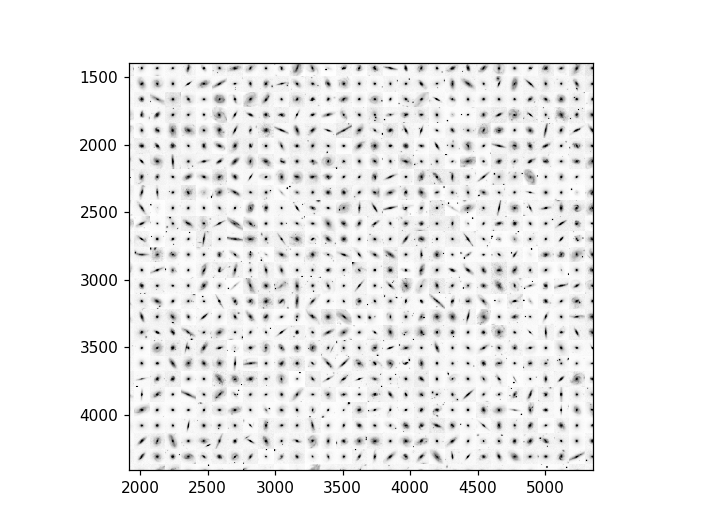

In [37]:
plt.imshow(sprite_image, cmap='gray')

In [38]:
plt.imsave(log_dir+'sprite.png', sprite_image, cmap='gray')

### B.  Calling Tensorboard without fit 

In [39]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

In [40]:
path_for_FO_DES_sprites =  os.path.join(log_dir,'sprite.png')
path_for_FO_DES_metadata =  os.path.join(log_dir,'metadata.tsv')

##### Create the embeddings

In [41]:
embedding_var = tf.Variable(FO_DES_out, name='second_last_layer_output')
summary_writer = tf.summary.FileWriter(log_dir)

##### Create the embeddings projector 

In [44]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_FO_DES_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_FO_DES_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([img_w,img_h])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

##### Saving the data 

In [45]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(log_dir, "model.ckpt"), 1)

'/home/khan74/scratch/new_DL_DES//deeplearning/tensorboard/metadata/FO_DES/model.ckpt-1'

In [46]:
log_dir

'/home/khan74/scratch/new_DL_DES//deeplearning/tensorboard/metadata/FO_DES/'

## 2. HP DES 

### Masking 

In [14]:
HP_DES_test_generator_NEW = valid_datagen.flow_from_directory(
HP_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 1066 images belonging to 1 classes.


In [15]:
HP_DES_predictions = model_final.predict_generator(HP_DES_test_generator_NEW, verbose=1)

1066/1066 [==============================] - 42s 40ms/step


In [16]:
mask = top_pred_mask(HP_DES_predictions, 1066)

In [17]:
HP_DES_predicted_class_indices=np.argmax(HP_DES_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in HP_DES_predicted_class_indices] )

filenames= np.array( HP_DES_test_generator_NEW.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred_Labels":predictions[mask],
                     "Predictions":HP_DES_predicted_class_indices[mask]})

In [18]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64')
final = pd.merge(results, HP_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']
final['Actual_Labels'] = final.apply(lambda row: 's' \
                                        if row.P_CS_DEBIASED > row.P_EL_DEBIASED \
                                        else 'e', axis=1)
final.Filename = final['Filename'].apply(lambda x: x.split('/')[-1] )

In [19]:
final[['OBJID', 'Filename', 'Actuals', 'Predictions', 'Actual_Labels', 'Pred_Labels']].head()

,OBJID,Filename,Actuals,Predictions,Actual_Labels,Pred_Labels
0,99995907,99995907.png,True,1,s,spiral
1,210963180,210963180.png,False,0,e,elliptical
2,224588398,224588398.png,False,0,e,elliptical
3,224584008,224584008.png,True,1,s,spiral
4,221563640,221563640.png,False,0,e,elliptical


In [20]:
metrics.accuracy_score(np.array(final.Actuals), np.array(final.Predictions))

0.9962476547842402

### A.  Tensorboard Metadata  

In [21]:
tsne_generator = valid_datagen.flow_from_dataframe(
dataframe = final,
directory = HP_DES_test_data_dir+ 'test/',
x_col = 'Filename',
y_col = 'Actual_Labels',
has_ext = True,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 1066 images.


In [22]:
clustering_model = Model(input = model_final.input, output = model_final.get_layer('second_last_layer').output)

/home/khan74/.conda/envs/myanaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [23]:
HP_DES_out = clustering_model.predict_generator(tsne_generator, verbose=1)

1066/1066 [==============================] - 11s 11ms/step


In [24]:
x_test = tsne_generator[0]

for i in range(tsne_generator.n - 1):
    x_test = np.concatenate( (x_test, tsne_generator[i+1]), axis=0 )

In [25]:
x_test.shape

(1066, 224, 224, 3)

#### Create Labels

In [26]:
labels=[]

for file in tsne_generator.filenames:
    labels.append( list(final.Actual_Labels[ final.Filename == file]) )

In [27]:
labels = np.squeeze(labels)

In [28]:
log_dir = PATH + '/deeplearning/tensorboard/metadata/HP_DES/'

if not exists(log_dir):
    makedirs(log_dir)

In [30]:
labels = np.array(labels)

# save class labels to disk to color data points in TensorBoard accordingly
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, labels, fmt="%s")

#### Create Sprites 

In [31]:
from scipy.misc import imresize

In [32]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    #img_h = int(8192 / n_plots)         # tensorboard supports sprite images up to 8192 x 8192
    #img_w = int(8192 / n_plots)
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                this_img = imresize( this_img, (img_h, img_w))
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage, img_w, img_h

In [33]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [34]:
def invert_grayscale(gray):
    """ Makes black white, and white black """
    return 1-gray

In [35]:
test_image = rgb2gray(x_test)

In [36]:
test_image = invert_grayscale(test_image)

In [39]:
sprite_image, img_w, img_h = create_sprite_image(test_image)

/home/khan74/.conda/envs/myanaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


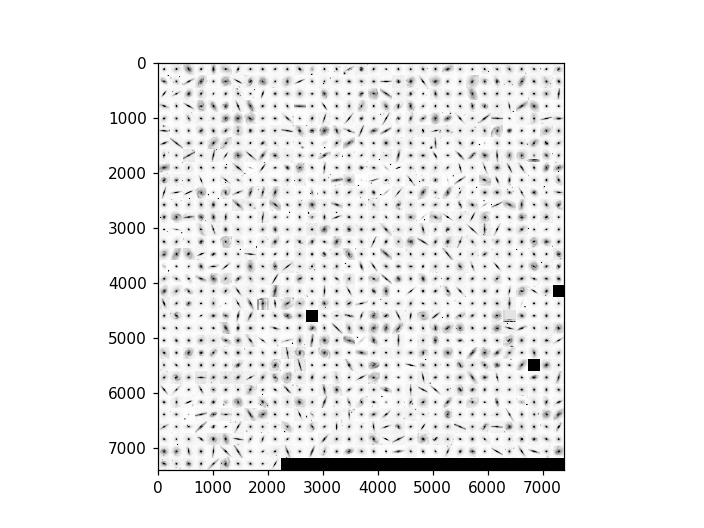

In [40]:
plt.imshow(sprite_image, cmap='gray')

In [41]:
plt.imsave(log_dir+'sprite.png', sprite_image, cmap='gray')

### B.  Calling Tensorboard without fit 

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector

In [43]:
path_for_HP_DES_sprites =  os.path.join(log_dir,'sprite.png')
path_for_HP_DES_metadata =  os.path.join(log_dir,'metadata.tsv')

##### Create the embeddings

In [44]:
embedding_var = tf.Variable(HP_DES_out, name='second_last_layer_output')
summary_writer = tf.summary.FileWriter(log_dir)

##### Create the embeddings projector 

In [47]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_HP_DES_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_HP_DES_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([img_w,img_h])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

##### Saving the data 

In [48]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(log_dir, "model.ckpt"), 1)

'/home/khan74/scratch/new_DL_DES//deeplearning/tensorboard/metadata/HP_DES/model.ckpt-1'

In [49]:
log_dir

'/home/khan74/scratch/new_DL_DES//deeplearning/tensorboard/metadata/HP_DES/'